In [1]:
import pandas as pd
import os
import matplotlib.pylab as pl
from pandas.tools.plotting import scatter_matrix
import statsmodels.formula.api as smf
import emcee
from scipy.cluster.vq import whiten
import geopandas as gp
import seaborn

import  corner
import scipy
from scipy.stats import norm as spnorm

import sys  
reload(sys)  
sys.setdefaultencoding('utf8')


%pylab inline

pl.rcParams['figure.figsize']= (10,10)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Loading Data

In [2]:
#Downloading Manhattan shapefile and moving it
os.system('curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip')
os.system('mv mn_mappluto_16v1.zip ' + os.getenv('PUIDATA'))
os.system('unzip ' + os.getenv('PUIDATA') + ' mn_mappluto_16v1.zip')

2304

In [3]:
#Reading Shapefile
bsize = gp.read_file(os.getenv('PUIDATA') + '/mappluto/MNMapPLUTO.shp')
bsize.head()

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.000000e+00,None,1592 2 AVENUE,C1-9/TA,None,2,468000.0,1435950.0,1.015450e+09,10885,...,0,1920,None,10028,C1-9,None,None,None,9a,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,1.007230e+09,11/30/2006,263 9 AVENUE,C1-5/R8,None,2,539984.0,11879993.0,1.007238e+09,89203,...,0,1914,None,10001,R8,None,None,None,8d,"POLYGON ((984164.5626000017 211846.0703999996,..."
2,0.000000e+00,None,310 EAST 109 STREET,R7A,None,2,140102.0,343271.0,1.016800e+09,12000,...,0,1910,None,10029,R7A,None,None,None,6b,"POLYGON ((1000742.195800006 227910.6640000045,..."
3,0.000000e+00,None,720 PARK AVENUE,R10/PI/LH-1A,R8B,2,5040000.0,30591900.0,1.013850e+09,203490,...,2006,1928,None,10021,R10,R8B,None,None,8c,"POLYGON ((994007.6886000037 219880.428399995, ..."
4,0.000000e+00,None,3 WEST 83 STREET,R8B,R10A,2,437850.0,1267200.0,1.011970e+09,13839,...,0,1900,None,10024,R8B,R10A,None,None,5d,"POLYGON ((992273.6850000024 224863.4904000014,..."


In [4]:
#Reading Local Law 84 Building Energy Data
nrg = pd.read_csv('https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD&bom=true&format=true')
nrg.dropna(subset=["NYC Borough, Block, and Lot (BBL)"], inplace=True)
nrg.head()

,﻿Record Number,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,Yes,None,NaN,NaN,NaN,NaN,NaN,"82,730",NaN,1.0
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,No,None,NaN,NaN,NaN,NaN,NaN,"440,360",NaN,1.0
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


In [5]:
bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [6]:
nrg.drop(['Co-reported BBL Status',
       'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Zip Code',
       'DOF Benchmarking Submission Status', 
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'], axis=1, inplace=True)

In [7]:
bsize.drop(['APPBBL', 'APPDate', 'Address', 'AllZoning1', 'AllZoning2',
       'AreaSource', 'AssessLand', 'AssessTot', 'BldgClass',
       'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
       'BuiltCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
       'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
       'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp',
       'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
       'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
       'ProxCode', 'ResidFAR', 'SHAPE_Area',
       'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDist',
       'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
       'Tract2010', 'Version', 'XCoord', 'YCoord',
       'YearAlter1', 'YearAlter2', 'ZMCode', 'ZipCode',
       'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'ZoneMap',
       'geometry'], axis=1, inplace=True)

In [8]:
nrg.rename(columns = {'NYC Borough, Block, and Lot (BBL)' : 'BBL'}, inplace=True)

In [9]:
bblnrgdata = pd.merge(nrg, bsize, how='inner', on = 'BBL')
bblnrgdata.dropna(subset=['Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)'], inplace=True)
bblnrgdata['Site EUI(kBtu/ft2)'] = pd.to_numeric(bblnrgdata['Site EUI(kBtu/ft2)'], errors='coerce')
bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'] =\
pd.to_numeric(bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')
bblnrgdata['nrg'] = bblnrgdata['Site EUI(kBtu/ft2)'] * bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)']
# bblnrgdata.drop('Record Number', axis=1, inplace=True)
bblnrgdata.head()

,﻿Record Number,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),BldgArea,GarageArea,NumBldgs,NumFloors,ResArea,RetailArea,UnitsRes,UnitsTotal,YearBuilt,nrg
2,3028,1.013110e+09,125.4,330000.0,313200,0,1,32.0,0,5378,0,56,1977,41382000.0
10,15011,1.010140e+09,154.9,841709.0,855000,0,1,32.0,0,77454,0,2,1999,130380724.1
15,977,1.007660e+09,122.3,59468.0,53168,0,1,8.0,0,0,0,8,1912,7272936.4
16,1256,1.008150e+09,117.0,364000.0,364000,0,1,22.0,0,11525,0,24,1954,42588000.0
18,500,1.005050e+09,82.1,235370.0,214110,0,1,10.0,0,21411,0,24,1926,19323877.0


In [10]:
bblnrgdata.describe()

,﻿Record Number,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),BldgArea,GarageArea,NumBldgs,NumFloors,ResArea,RetailArea,UnitsRes,UnitsTotal,YearBuilt,nrg
count,5219.000000,5.219000e+03,5.073000e+03,5.069000e+03,5.219000e+03,5219.000000,5219.000000,5219.000000,5.219000e+03,5.219000e+03,5219.000000,5219.000000,5219.000000,5.069000e+03
mean,3716.039471,1.012072e+09,1.162600e+03,2.151997e+05,2.141587e+05,4654.382257,1.349684,15.564284,1.058532e+05,9.264240e+03,103.489366,115.452769,1938.315194,2.136455e+08
std,3770.137382,5.557960e+06,4.274185e+04,3.255770e+05,3.821872e+05,22207.808683,1.663581,10.291550,2.132717e+05,3.528770e+04,262.341260,265.779864,105.406674,5.245490e+09
min,1.000000,1.000048e+09,0.000000e+00,1.000000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
25%,1464.000000,1.008260e+09,NaN,NaN,6.725700e+04,0.000000,1.000000,8.000000,0.000000e+00,0.000000e+00,0.000000,24.000000,1920.000000,NaN
50%,2909.000000,1.012420e+09,NaN,NaN,1.112310e+05,0.000000,1.000000,13.000000,6.202700e+04,2.000000e+03,54.000000,62.000000,1930.000000,NaN
75%,4321.500000,1.015248e+09,NaN,NaN,2.157360e+05,0.000000,1.000000,19.000000,1.274170e+05,9.095000e+03,115.000000,125.000000,1965.000000,NaN
max,15360.000000,1.022500e+09,3.018493e+06,9.515627e+06,1.343508e+07,527604.000000,38.000000,85.000000,8.367942e+06,1.176864e+06,8759.000000,8805.000000,2015.000000,3.501452e+11


# Removing Outliers

In [11]:
#removing obvious outliers
bblnrgdataCut = bblnrgdata[(bblnrgdata.nrg > 1000) * (bblnrgdata.UnitsTotal>=10) * 
                        (bblnrgdata.UnitsTotal<5e3) * (bblnrgdata.nrg < 1e11)]


# Estimating Error in Energy Measurements

In [12]:
## Assuming that there is error in the reported energy. 

#errors on the measured quantities
errorsnrg = np.sqrt((bblnrgdataCut['Reported Property Floor Area (Building(s)) (ft²)'])**2 +\
                (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))

## Assume count statistics in the number of units as well
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)

errorsInLogNrg = np.abs(errorsnrg / bblnrgdataCut.nrg / np.log(10))
errorsInLogUnits = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))

bblnrgdataCut['errorsnrg'] = errorsInLogNrg
bblnrgdataCut['errorsunits'] = errorsInLogUnits

bblnrgdataCut['nrglog'] = np.log10(bblnrgdataCut.nrg)
bblnrgdataCut['UnitsTotallog'] = np.log10(bblnrgdataCut.UnitsTotal)
bblnrgdataCut['errorlog'] = (bblnrgdataCut['errorsunits']**2 + bblnrgdataCut['errorsnrg']**2)**0.5

# Finding analytical solution in log - log space

In [13]:
A = np.vstack((np.ones_like(bblnrgdataCut.UnitsTotallog), bblnrgdataCut.UnitsTotallog)).T
C = np.diag(bblnrgdataCut.errorlog * bblnrgdataCut.errorlog)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, bblnrgdataCut.nrglog)))

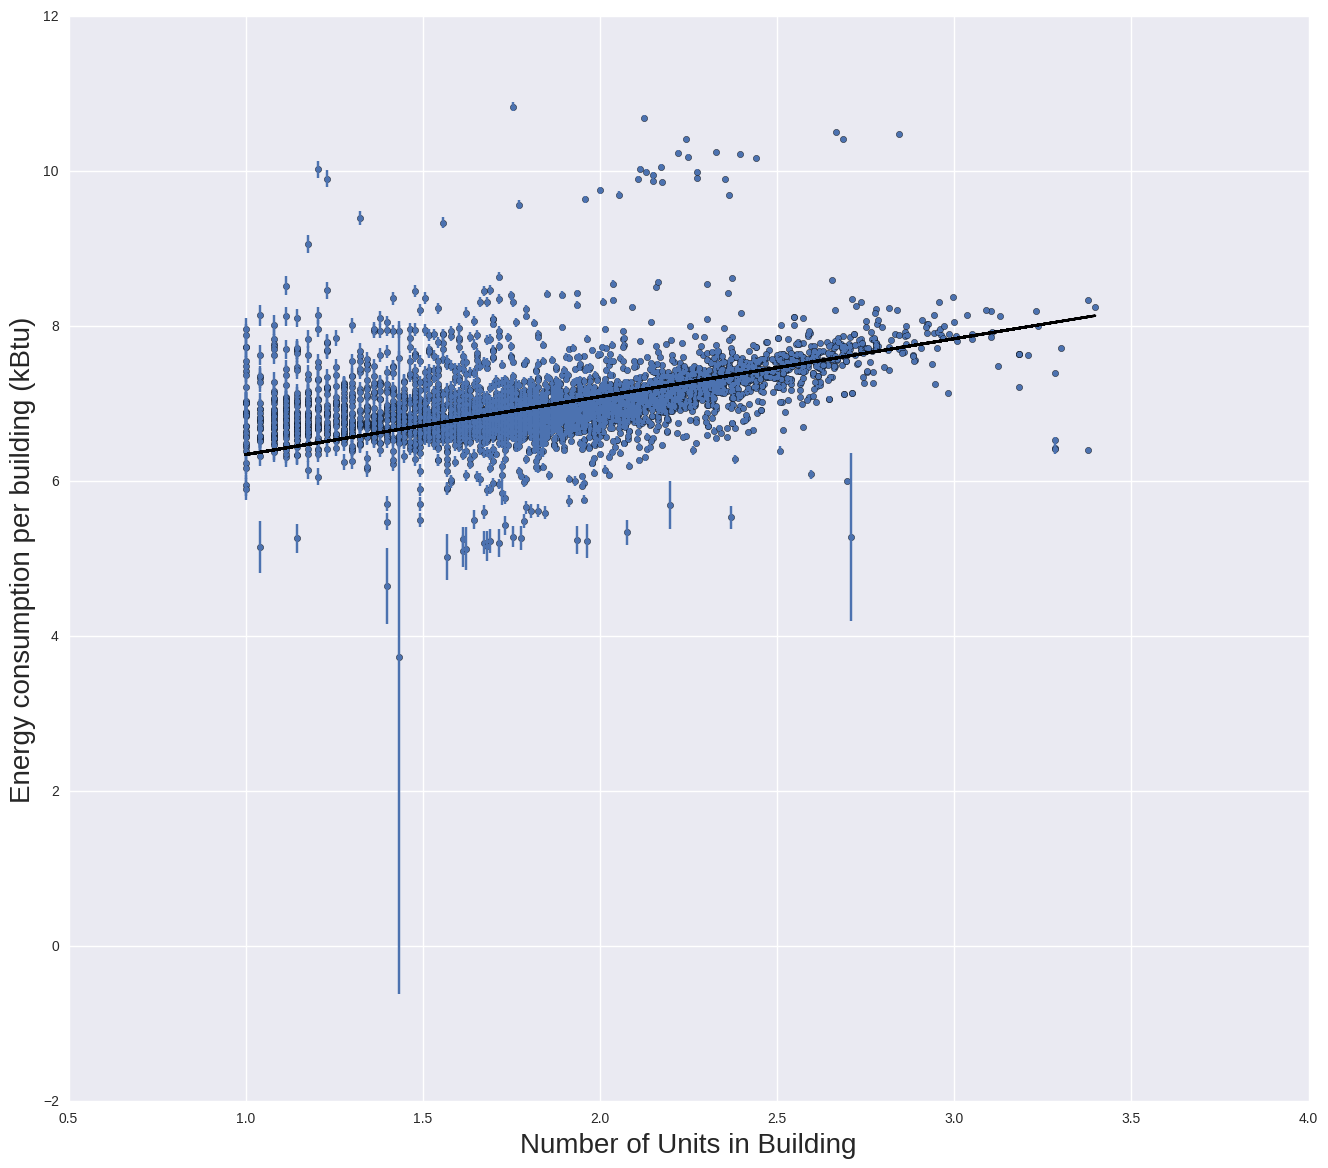

In [14]:
ax = bblnrgdataCut.plot(kind='scatter', y='nrglog', x='UnitsTotallog', yerr="errorlog",
                   marker='o',  figsize=(16, 14))#, loglog=True)
ax.plot(bblnrgdataCut.UnitsTotallog, b_ls + m_ls * bblnrgdataCut.UnitsTotallog, 'k-')
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

The above figure indicates the energy consumption increases as the number of units in a building increase and this increase is linear in the log-log space

# likelihood model based on chi-square for a line fit of units to energy

In [15]:
x = np.array(bblnrgdataCut.UnitsTotallog)
y = np.array(bblnrgdataCut.nrglog)
yerr = np.array(bblnrgdataCut.errorlog)

In [16]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [17]:
#Finding the maximum likelihood of the parameters
import scipy.optimize as op
nll = lambda *args: - lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls, np.log(1)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

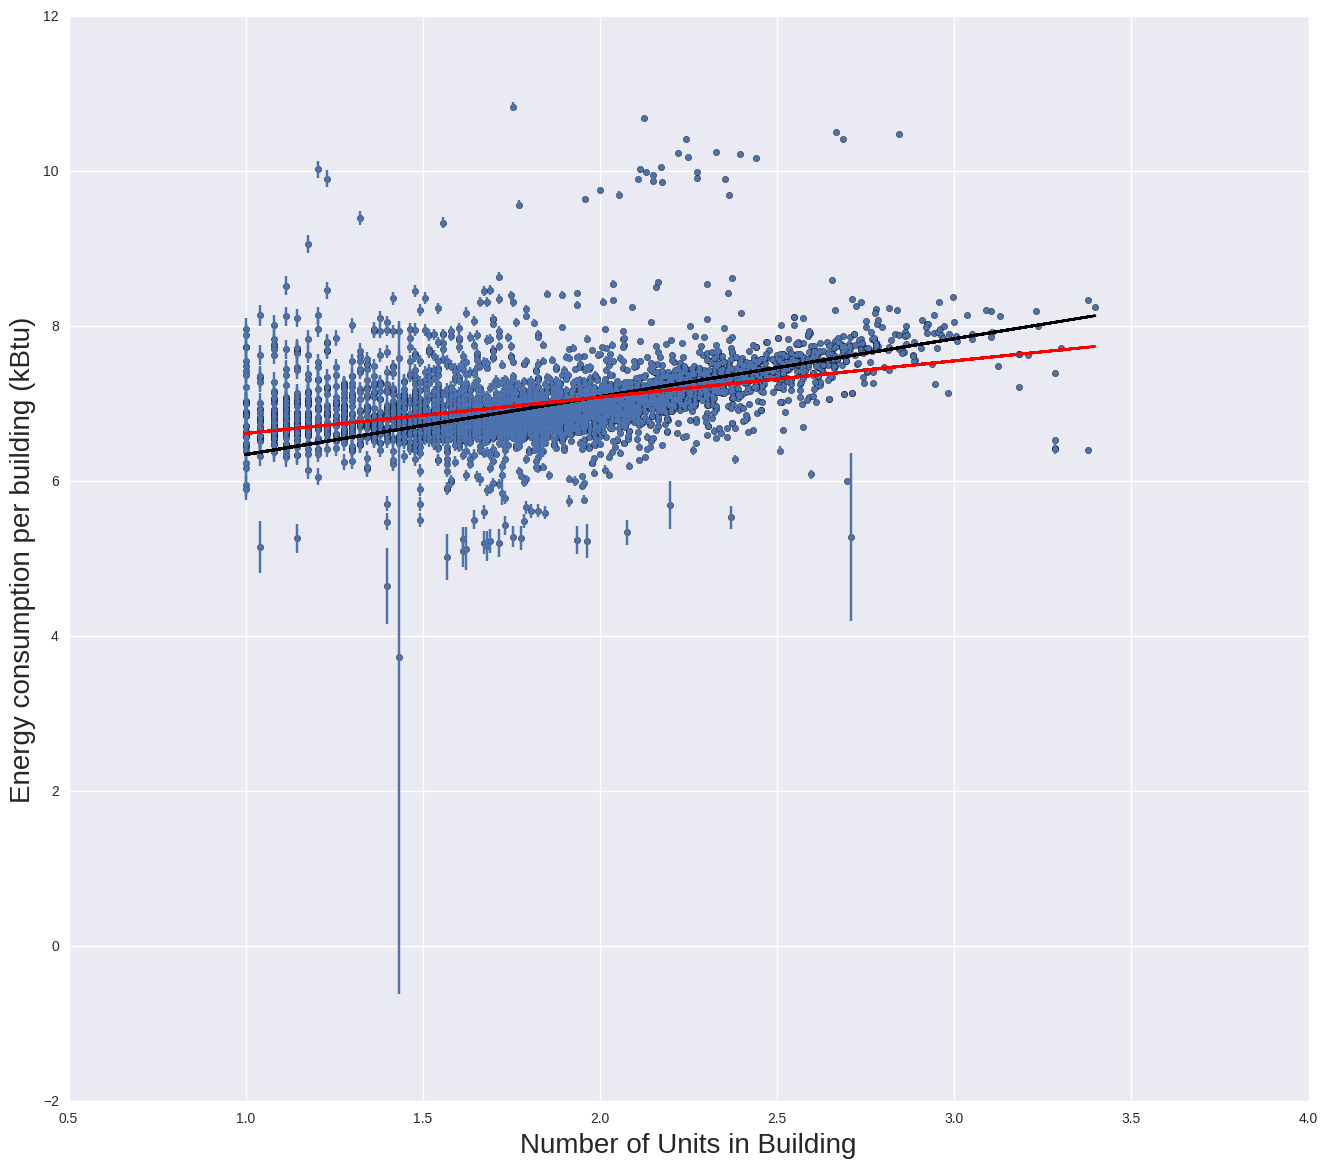

In [18]:
ax = bblnrgdataCut.plot(kind='scatter', y='nrglog', x='UnitsTotallog', yerr="errorlog",
                   marker='o',  figsize=(16, 14))#, loglog=True)
ax.plot(bblnrgdataCut.UnitsTotallog, b_ls + m_ls * bblnrgdataCut.UnitsTotallog, 'k-')
ax.plot(bblnrgdataCut.UnitsTotallog, b_ml + m_ml * bblnrgdataCut.UnitsTotallog, 'r-')
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

The above figure is a plot of Energy Consumption per Building to Number of Units in a Building in log-log space. The red line indicates the maximum likelihood estimate of the parameters. This estimate, as observed is a bit different than the least square solution as it corrects for the errors in the data.

### FItting the model to a second degree polynomial of the form energy = ax^2 + bx + c using Affine Invariant MCMC

In [19]:
#Estimate your model parameters and their confidence intervals
def lnprior(theta):
    a, m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [20]:
def lnlike(theta, x, y, yerr):
    a, b, c, lnf = theta
    model = a * (x ** 2) + b * x + c
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [21]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [22]:
#Setting a = 0
a = 0
b = m_ml
c = b_ml
f = lnf_ml

In [23]:
#Running MCMC
ndim, nwalkers = 4, 100
pos = [[a, b, c, f] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 500);

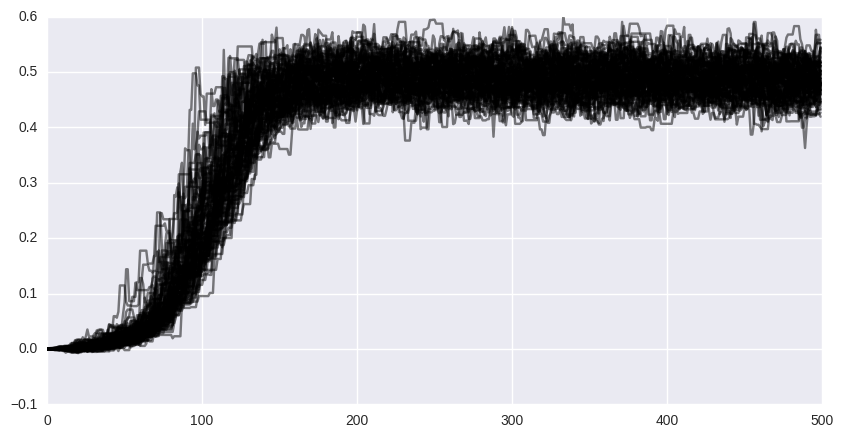

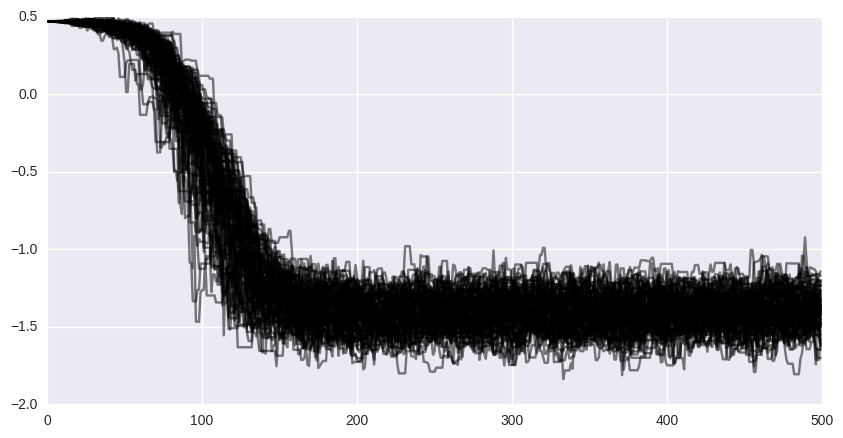

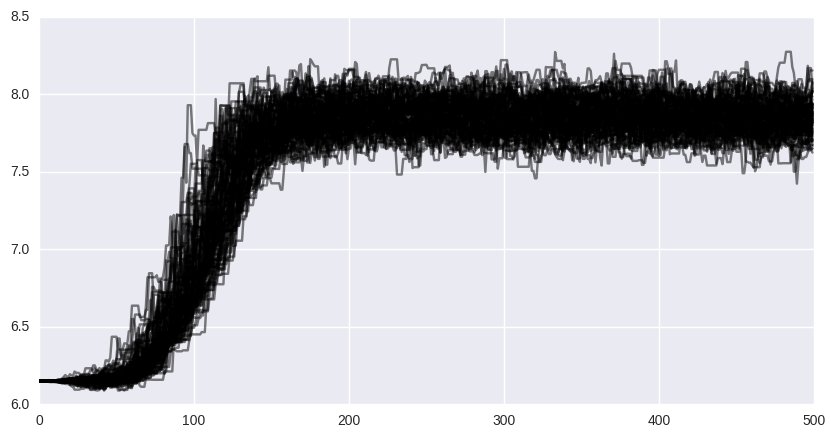

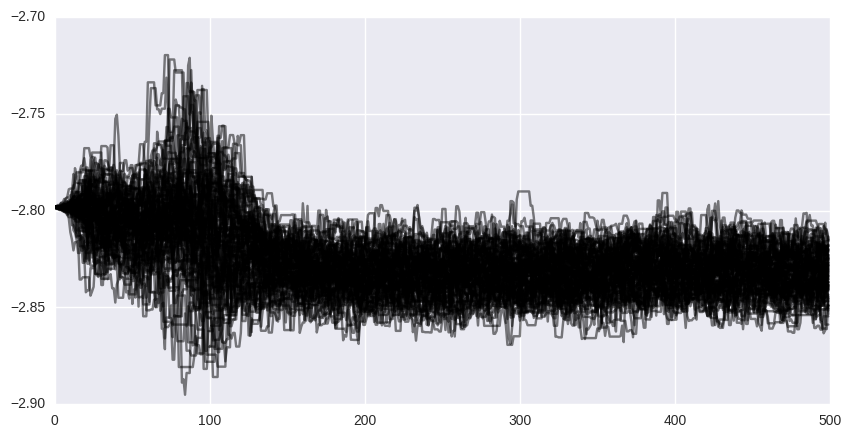

In [24]:
for i in range(ndim):
    pl.figure(figsize=(10,5))
    pl.plot(sampler.chain[:, :, i].T, 'k-', label="slope", alpha = 0.5)

As observed in the above plots the parameters stabalize near the optimal value after approx 100 steps.

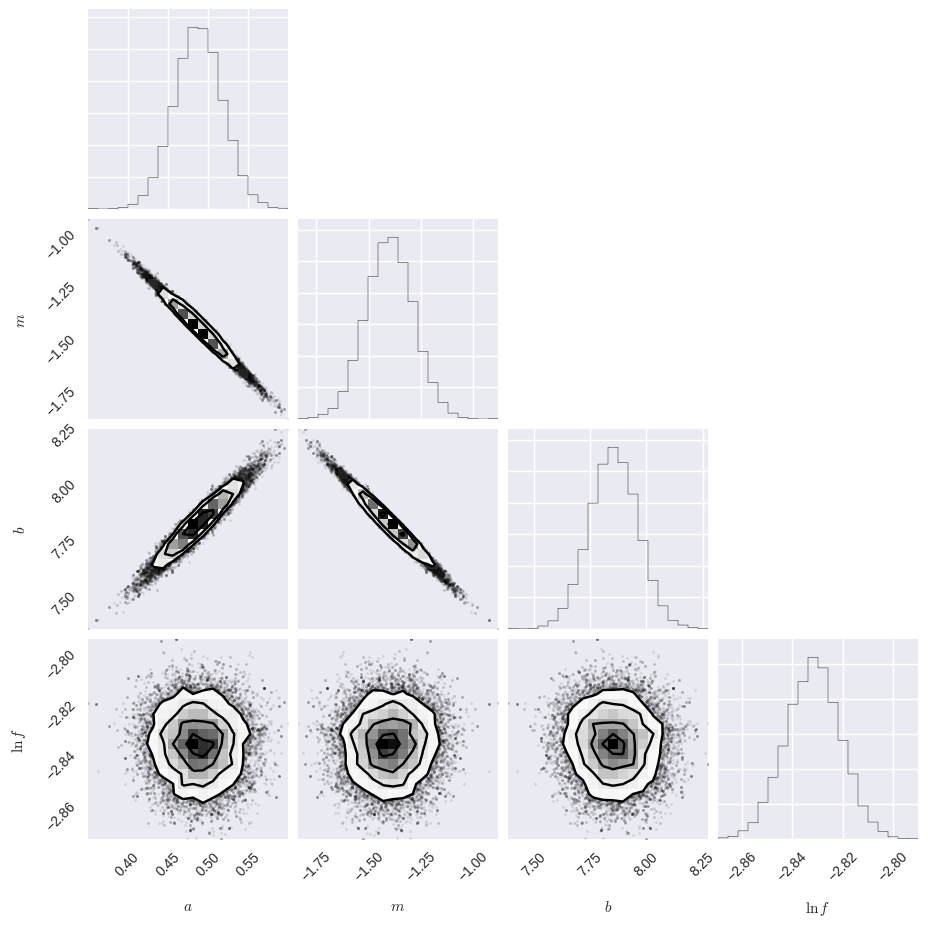

In [25]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["$a$", "$m$", "$b$", "$\ln\,f$"],
                      truths=[0, m_ls, b_ls, np.log(1)])

Postier Joint Distribution of the data

In [26]:
a_mcmc, m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [27]:
mcmcRes = np.concatenate([a_mcmc, m_mcmc, b_mcmc, f_mcmc])
mcmcRes

array([ 0.48818636,  0.02953152,  0.02955662, -1.39870592,  0.11228052,
        0.11445751,  7.85574463,  0.10600951,  0.10723541, -2.83156875,
        0.01076859,  0.01084771])

In [28]:
print ("MCMC result:\a\t\t{0:+.2f} ({1:.2f}, {2:.2f})\b\t{3:.2f} ({4:.2f}, {5:.2f}),\
\c\t\t{6:+.2f} ({7:.2f}, {8:.2f})\f\t{9:.2f} ({10:.2f}, {11:.2f})".format(*mcmcRes))

# chose 5 parameters from the set of record data available through Pluto or Local Law 84 and fit a multivariate linear model to the energy data. Correct your uncertainties by the correction factor you estimated in your earlier model

In [30]:
#Reading Shapefile
bsize = gp.read_file(os.getenv('PUIDATA') + '/mappluto/MNMapPLUTO.shp')
bsize.head()

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.000000e+00,None,1592 2 AVENUE,C1-9/TA,None,2,468000.0,1435950.0,1.015450e+09,10885,...,0,1920,None,10028,C1-9,None,None,None,9a,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,1.007230e+09,11/30/2006,263 9 AVENUE,C1-5/R8,None,2,539984.0,11879993.0,1.007238e+09,89203,...,0,1914,None,10001,R8,None,None,None,8d,"POLYGON ((984164.5626000017 211846.0703999996,..."
2,0.000000e+00,None,310 EAST 109 STREET,R7A,None,2,140102.0,343271.0,1.016800e+09,12000,...,0,1910,None,10029,R7A,None,None,None,6b,"POLYGON ((1000742.195800006 227910.6640000045,..."
3,0.000000e+00,None,720 PARK AVENUE,R10/PI/LH-1A,R8B,2,5040000.0,30591900.0,1.013850e+09,203490,...,2006,1928,None,10021,R10,R8B,None,None,8c,"POLYGON ((994007.6886000037 219880.428399995, ..."
4,0.000000e+00,None,3 WEST 83 STREET,R8B,R10A,2,437850.0,1267200.0,1.011970e+09,13839,...,0,1900,None,10024,R8B,R10A,None,None,5d,"POLYGON ((992273.6850000024 224863.4904000014,..."


In [34]:
bsizeMul = bsize[['BBL', 'AssessLand', 'UnitsRes', 'BldgArea',  'UnitsTotal', 'BldgDepth', 'NumFloors']]
bsizeMul.dropna(inplace=True)
bsizeMul.reset_index(inplace=True,drop=True)
bsizeMul.head()

,BBL,AssessLand,UnitsRes,BldgArea,UnitsTotal,BldgDepth,NumFloors
0,1.015450e+09,468000.0,16,10885,18,82.0,5.0
1,1.007238e+09,539984.0,50,89203,50,100.0,11.0
2,1.016800e+09,140102.0,10,12000,10,89.0,5.0
3,1.013850e+09,5040000.0,29,203490,32,141.0,17.0
4,1.011970e+09,437850.0,26,13839,26,84.0,5.0


In [35]:
#Reading Local Law 84 Building Energy Data
nrg = pd.read_csv('https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD&bom=true&format=true')
nrg.dropna(subset=["NYC Borough, Block, and Lot (BBL)"], inplace=True)
nrg.head()

,﻿Record Number,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,Yes,None,NaN,NaN,NaN,NaN,NaN,"82,730",NaN,1.0
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,No,None,NaN,NaN,NaN,NaN,NaN,"440,360",NaN,1.0
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


In [36]:
nrgMul = nrg[['NYC Borough, Block, and Lot (BBL)', 'Site EUI(kBtu/ft2)',\
              'Reported Property Floor Area (Building(s)) (ft²)', 'Total GHG Emissions(MtCO2e)']]
nrgMul.dropna(inplace=True)
nrgMul.rename(columns={'NYC Borough, Block, and Lot (BBL)' : 'BBL'}, inplace=True)
nrgMul.reset_index(inplace=True, drop=True)
nrgMul.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),Total GHG Emissions(MtCO2e)
0,1.013110e+09,125.4,330000,3556.4
1,1.010140e+09,154.9,841709,9525
2,4.002520e+09,46,390400,1356.2
3,4.004370e+09,66.2,528060,2641.2
4,1.007660e+09,122.3,59468,584.4


In [37]:
#Merging the tables
bblnrgdata = pd.merge(nrgMul,bsizeMul, on='BBL', how='inner')
bblnrgdata.dropna(inplace=True)
bblnrgdata.reset_index(inplace=True, drop=True)
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),Total GHG Emissions(MtCO2e),AssessLand,UnitsRes,BldgArea,UnitsTotal,BldgDepth,NumFloors
0,1.013110e+09,125.4,330000,3556.4,9270000.0,0,313200,56,145.0,32.0
1,1.010140e+09,154.9,841709,9525,19215000.0,0,855000,2,164.0,32.0
2,1.007660e+09,122.3,59468,584.4,616500.0,0,53168,8,83.0,8.0
3,1.008150e+09,117,364000,3613,11385000.0,0,364000,24,212.0,22.0
4,1.005050e+09,82.1,235370,1392.3,6030000.0,0,214110,24,100.0,10.0


In [38]:
#removing obvious outliers
bblnrgdata['Site EUI(kBtu/ft2)'] = pd.to_numeric(bblnrgdata['Site EUI(kBtu/ft2)'], errors='coerce')
bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'] =\
pd.to_numeric(bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')

bblnrgdata['Emissions'] = pd.to_numeric(bblnrgdata['Total GHG Emissions(MtCO2e)'], errors='coerce')


bblnrgdata['nrg'] = pd.to_numeric(bblnrgdata['Site EUI(kBtu/ft2)'], errors='coerce') * \
pd.to_numeric(bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')


bblnrgdataCut = bblnrgdata[(bblnrgdata.nrg > 1000) * (bblnrgdata.UnitsTotal>=10) * 
                        (bblnrgdata.UnitsTotal<5e3) * (bblnrgdata.nrg < 1e11)]

bblnrgdataCut = bblnrgdataCut.loc[~(bblnrgdataCut==0).any(axis=1)]
bblnrgdataCut.reset_index(inplace=True,drop=True)
bblnrgdataCut.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),Total GHG Emissions(MtCO2e),AssessLand,UnitsRes,BldgArea,UnitsTotal,BldgDepth,NumFloors,Emissions,nrg
0,1.021420e+09,137.7,64806.0,673.6,368550.0,54,64816,62,145.0,6.0,673.6,8.923786e+06
1,1.021750e+09,103.2,62839.0,485,490500.0,75,62847,85,100.0,6.0,485.0,6.484985e+06
2,1.003360e+09,74.0,98000.0,435.5,423000.0,128,98052,128,106.0,11.0,435.5,7.252000e+06
3,1.008580e+09,138.3,60110.0,597.29999999999995,1858500.0,56,60110,61,93.0,8.0,597.3,8.313213e+06
4,1.009688e+09,56909.0,457946.0,2307283.7000000002,18808199.0,485,457946,486,167.5,37.0,2307283.7,2.606125e+10


In [39]:
#Calculating log values of parameters
bblnrgdataCut['lognrg'] = np.log(bblnrgdataCut.nrg)
bblnrgdataCut['logUnitsRes'] = np.log(bblnrgdataCut.UnitsRes)
bblnrgdataCut['logAssessLandPerNumFloor'] = np.log(bblnrgdataCut.AssessLand)/np.log(bblnrgdataCut.NumFloors)
bblnrgdataCut['logBldgArea'] = np.log(bblnrgdataCut.BldgArea)
bblnrgdataCut['logUnitsTotal'] = np.log(bblnrgdataCut.UnitsTotal)
bblnrgdataCut['logEmissions'] = np.log(bblnrgdataCut['Emissions'])

In [40]:
#Calculating errors and error logs
errorsnrg = np.sqrt((bblnrgdataCut['Reported Property Floor Area (Building(s)) (ft²)'])**2 +\
                (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))

## Assume count statistics in the number of units as well
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)
errorsUnitsRes = np.sqrt(bblnrgdataCut.UnitsRes)
errorsAssessLandPerNumFloor = np.sqrt(bblnrgdataCut.AssessLand/bblnrgdataCut.NumFloors)
errorBldgArea = np.sqrt(bblnrgdataCut.BldgArea)
errorEmissions = np.sqrt(bblnrgdataCut.Emissions)


bblnrgdataCut['errorsnrglog'] = np.abs(errorsnrg / bblnrgdataCut.nrg / np.log(10))
bblnrgdataCut['errorsunitslog'] = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))
bblnrgdataCut['errorsUnitsReslog'] = np.abs(errorsUnitsRes / bblnrgdataCut.UnitsRes / np.log(10))
bblnrgdataCut['errorsAssessLandPerNumFloorlog'] = np.abs(errorsAssessLandPerNumFloor \
                                            / (bblnrgdataCut.AssessLand/bblnrgdataCut.NumFloors) / np.log(10))
bblnrgdataCut['errorsBldgArealog'] = np.abs(errorBldgArea / bblnrgdataCut.BldgArea / np.log(10))
bblnrgdataCut['errorsEmissionslog'] = np.abs(errorEmissions / bblnrgdataCut.Emissions / np.log(10))

bblnrgdataCut['errorLog'] = (bblnrgdataCut.errorsEmissionslog ** 2 + bblnrgdataCut.errorsunitslog ** 2 \
                + bblnrgdataCut.errorsUnitsReslog**2 + bblnrgdataCut.errorsAssessLandPerNumFloorlog ** 2 \
                + bblnrgdataCut.errorsnrglog ** 2 + bblnrgdataCut.errorsBldgArealog ** 2) ** 0.5

In [41]:
results = smf.ols('lognrg ~ logUnitsRes + logAssessLandPerNumFloor\
        +logBldgArea + logUnitsTotal + logEmissions', data=bblnrgdataCut).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 4.254e+04
Date:                Fri, 28 Jul 2017   Prob (F-statistic):               0.00
Time:                        21:56:32   Log-Likelihood:                 1958.0
No. Observations:                3044   AIC:                            -3904.
Df Residuals:                    3038   BIC:                            -3868.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                    9.6426      0.058    166.556      0.000         9.529     9.756
logUnitsRes                  0.0237      0.010      2.337      0.020         0.004     0.044
logAssessLandPerNumFloor     0.0094      0.002      4.304      0.000         0.005     0.014
logBldgArea                 -0.0184      0.006     -3.008      0.003        -0.030    -0.006
logUnitsTotal                0.0216      0.012      1.820      0.069        -0.002     0.045
logEmissions                 0.9778      0.003    346.558      0.000         0.972     0.983
==============================================================================
Omnibus:                      732.147   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42496.010
Skew:                           0.080   Prob(JB):                         0.00
Kurtosis:                      21.304   Cond. No.                         404.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As observed in the above linear fit, the R squared is 0.986. It is possibly an overfit as well as observing from the coefficients and standard errors the regression suffers from multicollinearity.

In [42]:
results.params
m = results.params[1:]
c = results.params[0]

In [43]:
#whitening the data before running MCMC
y = whiten(np.array(bblnrgdataCut.nrg))
x = whiten(np.array(bblnrgdataCut.ix[:,['logAssessLandPerNumFloor' ,'logUnitsRes' \
                                        ,'logBldgArea' , 'logUnitsTotal' , 'logEmissions']]))
yerr = whiten(np.array(bblnrgdataCut['errorLog']))

In [44]:
#Estimate your model parameters and their confidence intervals
def lnprior(theta):
    m0, m1, m2, m3, m4, c, lnf = theta
    if -5.0 < m0 < 0.5 and 0.0 < c < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta, x, y, yerr):
    m1, m2, m3, m4, m5, c, lnf = theta
    model = m[0] * x[:,0] + m[1] * x[:,1] + m[2] * x[:,2] + m[3] * x[:,3] + m[4] * x[:,4] + c
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [45]:
#Running MCMC using analytical solution as the starting point of the simualation
ndim, nwalkers = 7, 100
pos = [[m[0], m[1], m[2], m[3], m[4], c, np.log(1)] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 500);

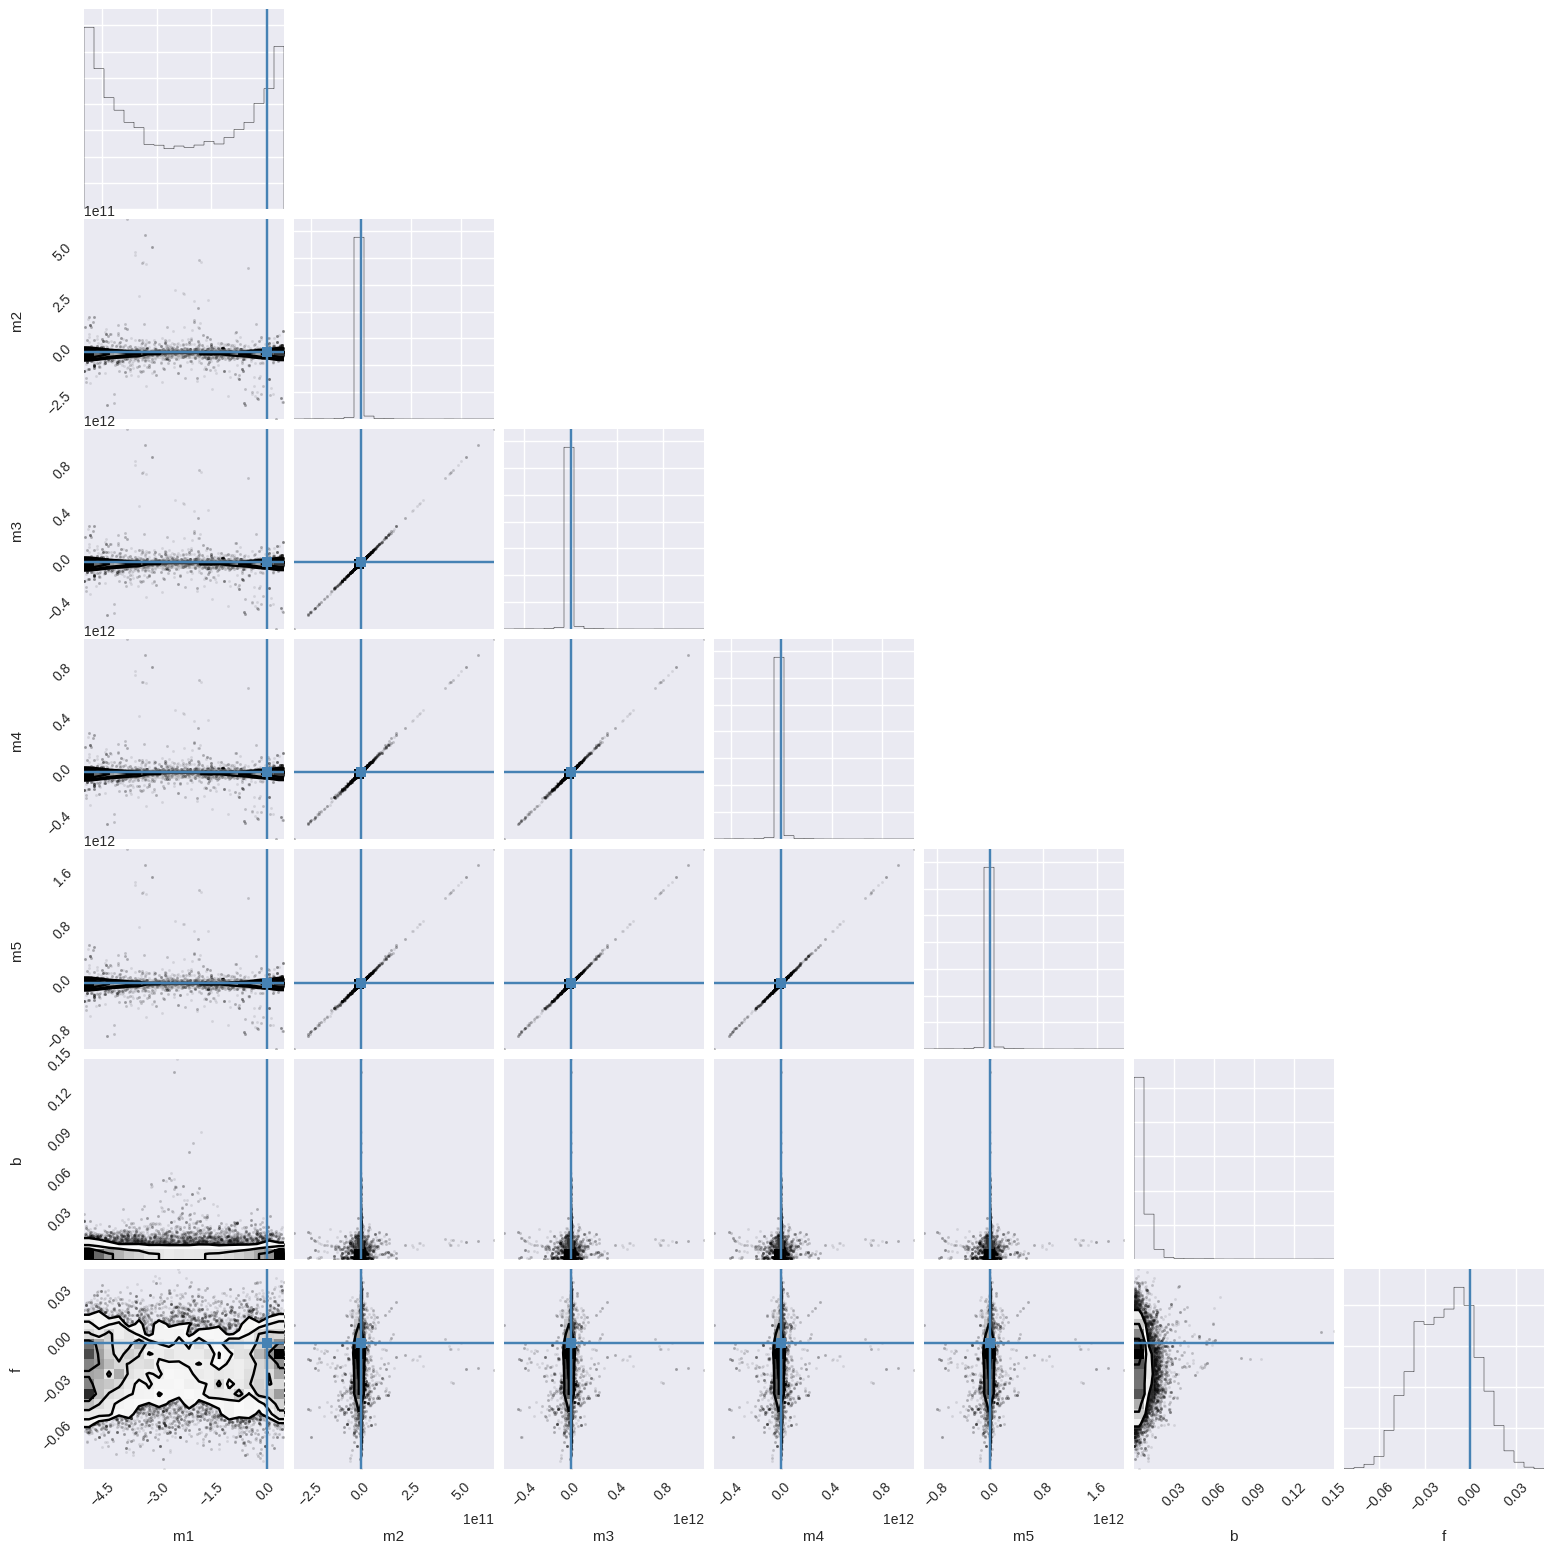

In [46]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["m1","m2","m3","m4","m5","b","f"],
                      truths=[m[0], m[1], m[2], m[3], m[4], c, np.log(1)])

The corner plot is demonstrating the skewed joint distribution possibly due to the multicollinearlity between the regressors.